In [ ]:
'''
Analysis of distribution of cell types
'''

In [1]:
import pandas as pd
import scanpy as sc
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
from scipy.stats import fisher_exact
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
warnings.filterwarnings('ignore')

In [16]:
# Cell type files filepath
HUMAN_CT_FP = '/large_storage/goodarzilab/arshian/state_ct_obs/Homo_sapiens'
# Metadata filepath
META_FP = '/large_storage/ctc/public/scBasecamp/metadata_tsp_annotated_2.parquet'
CT_DISTRIBUTIONS = 'cell_type_distributions'

In [17]:
# Get metadata
metadata = pd.read_parquet(META_FP)

In [18]:
with open(CT_DISTRIBUTIONS + '/cell_type_distributions_08_15_2025_cleaned.json', 'r') as file:
    tissue_to_cts = json.load(file)
with open(CT_DISTRIBUTIONS + '/ct_categorized_ontology_08_16_2025.json', 'r') as file:
    cell_type_mapping = json.load(file)

In [19]:
def map_and_aggregate_data(tissue_dict, cell_type_mapping):
    mapped_data = {}
    
    for tissue, cell_counts in tissue_dict.items():
        if not cell_counts:
            continue
            
        mapped_data[tissue] = {}
        for cell_type, count in cell_counts.items():
            if cell_type in cell_type_mapping:
                broad_category = cell_type_mapping[cell_type]
                if broad_category not in mapped_data[tissue]:
                    mapped_data[tissue][broad_category] = 0
                mapped_data[tissue][broad_category] += count
    
    return mapped_data

def find_shared_cell_types(tissue_dict, n=5):
    """
    Find cell types that appear in n or more tissues.
    """
    cell_type_count = {}
    
    for tissue, cells in tissue_dict.items():
        for cell_type in cells.keys():
            cell_type_count[cell_type] = cell_type_count.get(cell_type, 0) + 1
            
    return {cell_type: count for cell_type, count in cell_type_count.items() 
            if count >= n}

def top_cell_types_df(mapped_tissue_to_ct_dict, cell_types_top):
    mapped_top = {}
    for tissue in mapped_tissue_to_ct_dict:
        tissue_dict = {}
        other_sum = 0
        
        for k, v in mapped_tissue_to_ct_dict[tissue].items():
            if k in cell_types_top:
                tissue_dict[k] = v
            else:
                other_sum += v
        
        if other_sum > 0:
            tissue_dict['other'] = other_sum
        
        mapped_top[tissue] = tissue_dict
    return pd.DataFrame(mapped_top).T.fillna(0)

In [20]:
def plot_heatmap(df, title, legend_label, figsize=(12, 8), cmap="Blues", dpi=300, save_path=None, format='svg', vmin=None, vmax=None):
    plt.figure(figsize=figsize, dpi=dpi)
    
    mask = df == 0
    
    sns.heatmap(df, 
                cbar_kws={'label': legend_label, 'shrink': 0.8},
                annot=True,
                fmt='.2f',
                cmap=cmap,
                linewidths=0.5,
                linecolor='white',
                vmin=vmin,
                vmax=vmax,
                mask=mask)
    
    sns.heatmap(df, 
                cbar=False,
                annot=False,
                cmap=['lightgray'],
                linewidths=0.5,
                linecolor='white',
                mask=~mask)
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Cell Type Category', fontsize=14)
    plt.ylabel('Tissue', fontsize=14)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}.{format}", 
                   format=format,
                   dpi=dpi if format == 'png' else None,
                   bbox_inches='tight',
                   facecolor='white',
                   edgecolor='none')
        print(f"Plot saved as {save_path}.{format}")
        
    plt.show()

In [21]:
# Remove 'brain' category
tissue_to_cts.pop('brain')

{'neuron': 6371363,
 'oligodendrocyte': 5389892,
 'astrocyte': 1735957,
 'oligodendrocyte precursor cell': 535665,
 'central nervous system macrophage': 2174332,
 'endothelial cell': 315131,
 'pericyte': 114022,
 'vascular associated smooth muscle cell': 1035721,
 'fibroblast': 401488,
 'leukocyte': 1608102,
 'ependymal cell': 479001,
 'choroid plexus epithelial cell': 100404,
 'Bergmann glial cell': 19230}

In [22]:
mapped = map_and_aggregate_data(tissue_to_cts, cell_type_mapping)
cell_types_top = find_shared_cell_types(mapped, n=5).keys()
df_top = top_cell_types_df(mapped, cell_types_top)

In [23]:
tissue_mapping = {
    'blood': 'blood',
    'brain': 'brain',
    'bonemarrow': 'bone marrow',
    'lung': 'lung',
    'spleen': 'spleen',
    'eye': 'eye',
    'liver': 'liver',
    'skin': 'skin',
    'muscle': 'muscle',
    'si': 'small intestine',
    'mammary': 'mammary',
    'pancreas': 'pancreas',
    'lymphnode': 'lymph node',
    'heart': 'heart',
    'li': 'large intestine',
    'vasculature': 'vasculature',
    'fat': 'fat',
    'endometrium': 'endometrium',
    'prostate': 'prostate',
    'bladder': 'bladder',
    'trachea': 'trachea',
    'salivarygland': 'salivary gland',
    'tongue': 'tongue',
    'thymus': 'thymus'
}

df_top.index = df_top.index.map(tissue_mapping)

In [24]:
order = ['T cell', 'B cell', 'neutrophil', 'monocyte', 
         'macrophage', 'plasma cell', 'natural killer cell', 'other leukocyte', 'erythrocyte', 'hematopoietic precursor cell',
         'epithelial cell', 'endothelial cell', 'muscle cell', 'fibroblast', 'other connective tissue cell', 'progenitor/stem cell', 'other']
df_sorted = df_top[order]

Plot saved as ../images/final/heatmap_log_count_no_numbers.svg


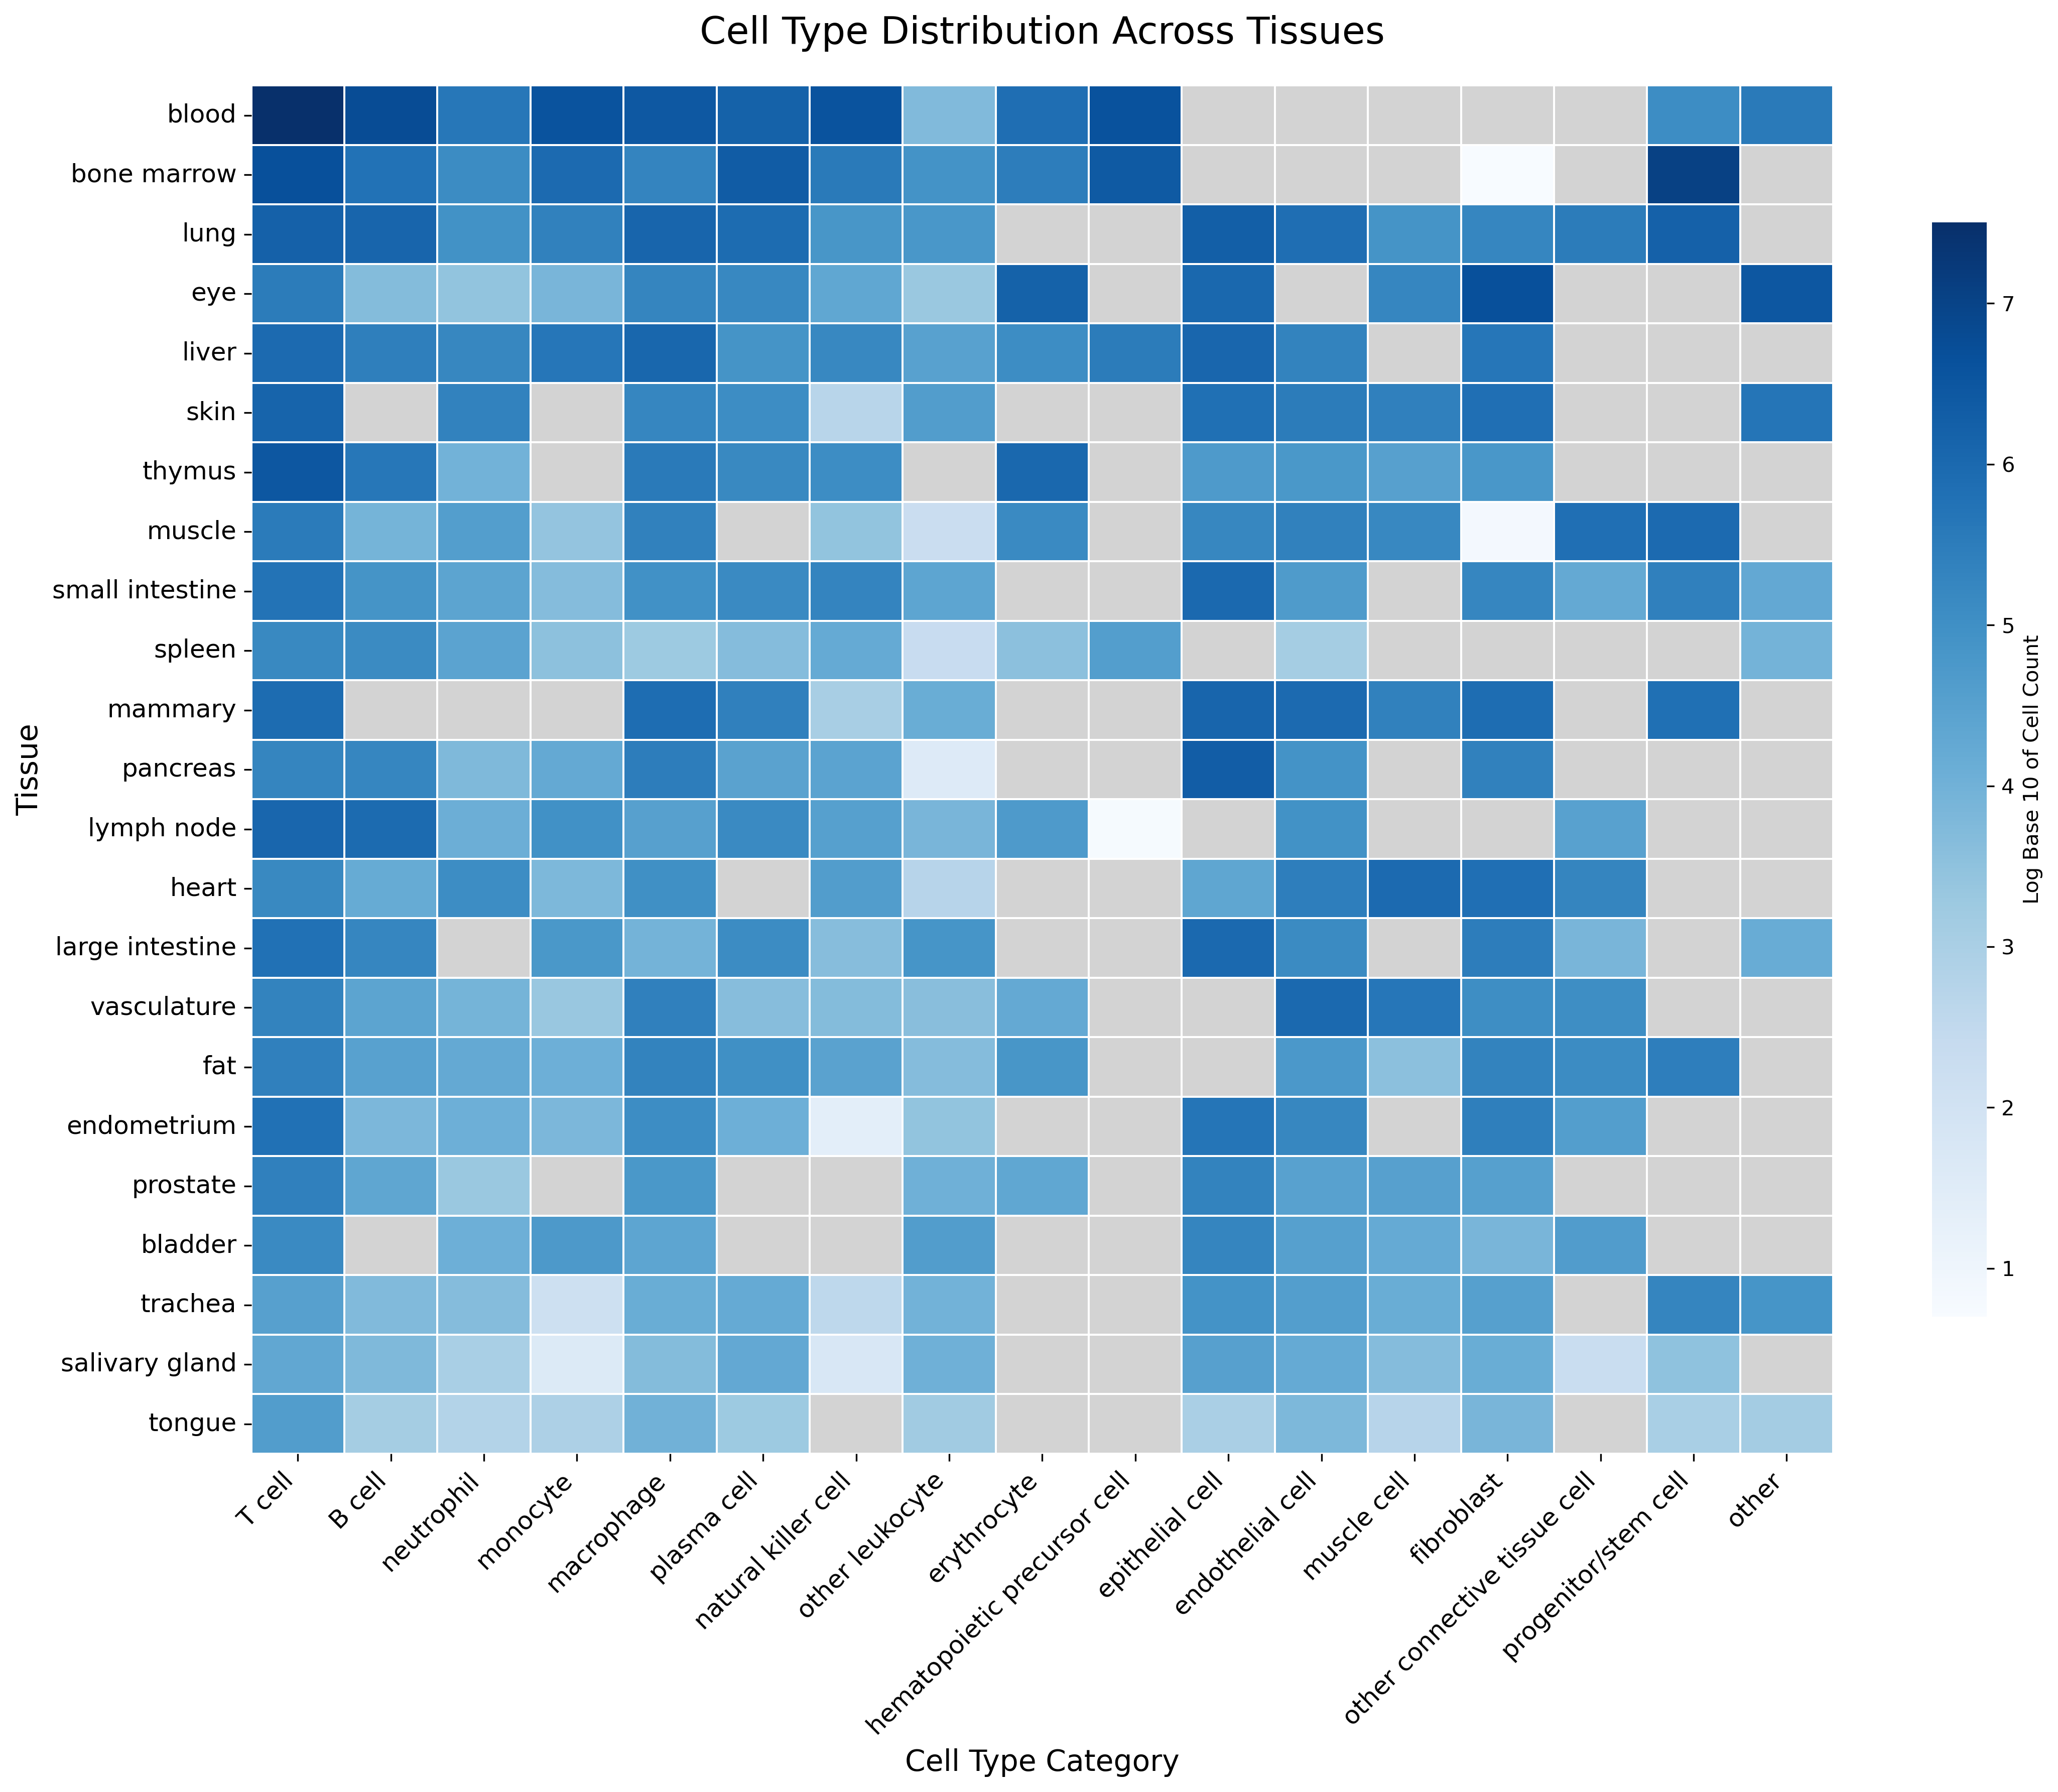

In [31]:
log_df = np.log10(df_sorted + 1)
plot_heatmap(log_df, "Cell Type Distribution Across Tissues", figsize=(15, 12), save_path="../images/final/heatmap_log_count_no_numbers", format='svg', legend_label="Log Base 10 of Cell Count")